In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

class Box2D:
    def __init__(self, x, y, yaw, corner_points=None, v=0.0):
        self.x0 = x
        self.y0 = y
        self.x = x
        self.y = y
        self.yaw = yaw
        self.corner_points = corner_points
        self.inflat_cpoints = []
        self.v = v
    def reset_xy(self):
        self.x = self.x0
        self.y = self.y0
        
    def update_once(self, dt):
        self.x += self.v*dt*math.cos(self.yaw)
        self.y += self.v*dt*math.sin(self.yaw)
    def inflation_obs(self, r):
        A = []
        for i in range(len(self.corner_points[0])-1):
            v1 = [self.corner_points[0, i], self.corner_points[1, i]]
            v2 = [self.corner_points[0, i+1], self.corner_points[1, i+1]]
            a = v2[0] - v1[0]
            b = v1[1] - v2[1]
            c = v1[1]*a+v1[0]*b
            inflat_c = -r*math.sqrt(a*a+b*b)+c
            A.append([a, b, inflat_c])
        pre_ind = -1
        for i in range(len(A)):
            a1, b1, c1 = A[pre_ind][1], A[pre_ind][0], A[pre_ind][2]
            a2, b2, c2 = A[i][1], A[i][0], A[i][2]
            x = (b2*c1-b1*c2)/(a1*b2-a2*b1)
            y = (a1*c2-a2*c1)/(a1*b2-a2*b1)  
            self.inflat_cpoints.append([x, y])
            pre_ind = i
        self.inflat_cpoints.append(self.inflat_cpoints[0])   
        self.inflat_cpoints = np.array(self.inflat_cpoints).T
        
        
car_corner_points = np.array([[2.0, -2.0, -2.0, 2.0, 2.0],
                              [1.0, 1.0, -1.0, -1.0, 1.0]])
road_bound_points = np.array([[100.0, -15.0, -15.0, 100.0, 100.0],
                              [0.1, 0.1, -0.1, -0.1, 0.1]])


road_bound_left = Box2D(0.0, 3.5, 0.0, corner_points=road_bound_points)
road_bound_right = Box2D(0.0, -3.5, 0.0, corner_points=road_bound_points)

car1 = Box2D(1.0, 1.7, 0.0, corner_points=car_corner_points, v=0.0)
car2 = Box2D(20.0, -1.7, 0.0, corner_points=car_corner_points, v=0.0)
car3 = Box2D(45.0, 1.7, 0.0, corner_points=car_corner_points, v=0.0)
ego = Box2D(0.0, -1.7, 0.0, corner_points=car_corner_points, v=0.0)
obs_buf = [car1, car2, car3]
road_bound_left.inflation_obs(1.4)
road_bound_right.inflation_obs(1.4)
for obs in obs_buf:
    obs.inflation_obs(1.4)
    
def local2global(x0, y0, yaw0, corner_points):
    R = np.array([[math.cos(yaw0), -math.sin(yaw0)],
                  [math.sin(yaw0), math.cos(yaw0)]])
    corner_arr = np.array(corner_points)
    return np.dot(R, corner_arr)+np.array([[x0],[y0]])


MAP_lines = []
MAP_cars = []
for obs in obs_buf:
    gcp0 = local2global(obs.x, obs.y, obs.yaw, obs.inflat_cpoints)
    for j in range(len(gcp0[0])-1):
        MAP_lines.append([gcp0[0][j], gcp0[1][j], gcp0[0][j+1], gcp0[1][j+1]])      
    
    gcp_car = local2global(obs.x, obs.y, obs.yaw, obs.corner_points)
    for j in range(len(gcp_car[0])-1):
        MAP_cars.append([gcp_car[0][j], gcp_car[1][j], gcp_car[0][j+1], gcp_car[1][j+1]])     

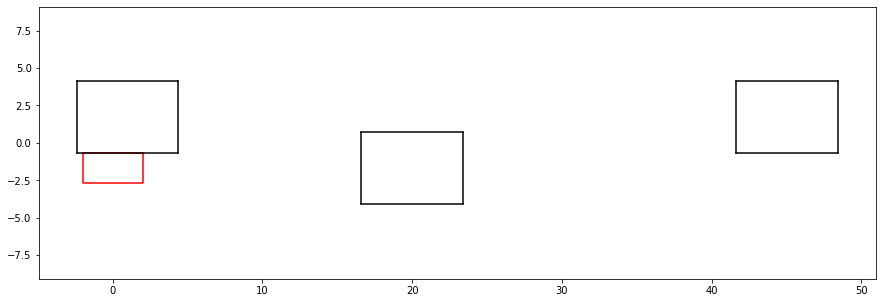

In [2]:
plt.figure(figsize=(15,5)) 
ego_cps = local2global(ego.x, ego.y, ego.yaw, ego.corner_points)
plt.plot(ego_cps[0], ego_cps[1], 'r')
for line in MAP_lines:
    plt.plot([line[0], line[2]], [line[1], line[3]], 'k')
plt.axis('equal')    
plt.show()

In [3]:
class AABB:
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        
        
def BOX2AABB(obs):
    gcp0 = local2global(obs.x, obs.y, obs.yaw, obs.inflat_cpoints)
    x_min = np.min(gcp0[0, :])
    x_max = np.max(gcp0[0, :])
    y_min = np.min(gcp0[1, :])
    y_max = np.max(gcp0[1, :])    
    print(x_min, x_max, y_min, y_max)
    return AABB(x_min, x_max, y_min, y_max)
    

N = 100
x_end = 60.0
dx = x_end/N
X = np.linspace(0, x_end, N)

# init by road boundary
LB = np.ones(N)*BOX2AABB(road_bound_right).y_max
UB = np.ones(N)*BOX2AABB(road_bound_left).y_min


# update by obs
for obs in obs_buf:
    obs_aabb = BOX2AABB(obs)
    start_x_idx = min(max(int(obs_aabb.x_min/dx), 0), N-1)
    end_x_idx = min(max(int(obs_aabb.x_max/dx), 0), N-1)
    if obs_aabb.y_min > LB[start_x_idx] and obs_aabb.y_min < UB[start_x_idx]:
        for i in range(start_x_idx, end_x_idx):
            UB[i] = obs_aabb.y_min
    if obs_aabb.y_max < UB[start_x_idx] and obs_aabb.y_max > LB[start_x_idx]:
        for i in range(start_x_idx, end_x_idx):
            LB[i] = obs_aabb.y_max        
print(LB, UB)            

-16.4 101.4 -5.0 -2.0
-16.4 101.4 2.0 5.0
-2.4 4.4 -0.7 4.1
16.6 23.4 -4.1 0.7
41.6 48.4 -0.7 4.1
[-2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
 -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.   0.7
  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7 -2.  -2.  -2.
 -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
 -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
 -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
 -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
 -2.  -2. ] [-0.7 -0.7 -0.7 -0.7 -0.7 -0.7 -0.7  2.   2.   2.   2.   2.   2.   2.
  2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
  2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
  2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
  2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.  -0.7
 -0.7 -0.7 -0.7 -0.7 -0.7 -0.7 -0.7 -0.7 -0.7 -0

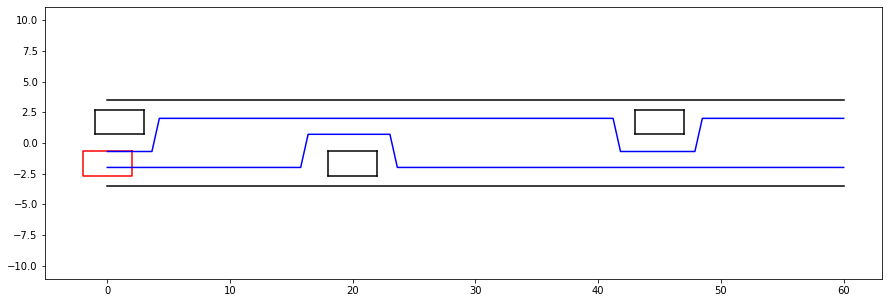

In [10]:
plt.figure(figsize=(15,5)) 
ego_cps = local2global(ego.x, ego.y, ego.yaw, ego.corner_points)
plt.plot(ego_cps[0], ego_cps[1], 'r')
for line in MAP_cars:
    plt.plot([line[0], line[2]], [line[1], line[3]], 'k')
plt.plot(X, road_bound_left.y*np.ones(N), 'k')
plt.plot(X, road_bound_right.y*np.ones(N), 'k')
plt.plot(X, LB, 'b')
plt.plot(X, UB, 'b')
plt.axis('equal')    
plt.show()

In [27]:
from pyomo.environ import *
from pyomo.dae import *

s = 3
m = ConcreteModel()
lb = {}
ub = {}
for i in range(N):
    lb[i] = LB[i]
    ub[i] = UB[i]
# Parameters
m.p0 = Param(initialize=ego.y, mutable=True)
m.coeffs = Param(RangeSet(0, 5), initialize={0:10.0, 1:100.0, 2:10.0, 3:1000.0})
m.LB = Param(RangeSet(0, N-1), initialize=lb)
m.UB = Param(RangeSet(0, N-1), initialize=ub)
m.c = Var(RangeSet(0, 2*s-1))
m.pt = Var(RangeSet(0, 3), RangeSet(0, N-1))


#Constrainsts
pw = {(0, 0):1.0, (0, 1):1.0, (0, 2):1.0, (0, 3):1.0, (0, 4):1.0, (0, 5):1.0,
      (1, 0):0.0, (1, 1):5.0, (1, 2):4.0, (1, 3):3.0, (1, 4):2.0, (1, 5):1.0,
      (2, 0):0.0, (2, 1):0.0, (2, 2):20.0,(2, 3):12.0,(2, 4):6.0, (2, 5):2.0,
      (3, 0):0.0, (3, 1):0.0, (3, 2):0.0, (3, 3):60.0,(3, 4):24.0,(3, 5):6.0}

m.pw = Param(RangeSet(0, 3), RangeSet(0, 5), initialize=pw)

m.dx = Param(initialize=dx)

def _polyfun(m, k, i):
    return (m.pt[k, i] == m.pw[k, 0]*m.c[max(0-k, 0)]*(m.dx*i)**5+
                          m.pw[k, 1]*m.c[max(1-k, 0)]*(m.dx*i)**4+
                          m.pw[k, 2]*m.c[max(2-k, 0)]*(m.dx*i)**3+
                          m.pw[k, 3]*m.c[max(3-k, 0)]*(m.dx*i)**2+
                          m.pw[k, 4]*m.c[max(4-k, 0)]*(m.dx*i)**1+
                          m.pw[k, 5]*m.c[max(5-k, 0)])

m.pt_con = Constraint(RangeSet(0, 3), RangeSet(0, N-1), rule=_polyfun)
m.pt_low_bound = Constraint(RangeSet(0, N-1), rule=lambda m, i : m.LB[i] <= m.pt[0, i])
m.pt_up_bound = Constraint(RangeSet(0, N-1), rule=lambda m, i : m.pt[0, i] <= m.UB[i])
m.p0_con = Constraint(rule=lambda m : m.pt[0, 0] == ego.y)
m.pN_con = Constraint(rule=lambda m : m.pt[0, N-1] == ego.y)
m.dp0_con = Constraint(rule=lambda m : m.pt[1, 0] == 0.0)
m.dpN_con = Constraint(rule=lambda m : m.pt[1, N-1] == 0.0)


m.dyobj = m.coeffs[0]*sum(m.pt[1, k]**2 for k in RangeSet(0, N-1))
m.ddyobj = m.coeffs[1]*sum(m.pt[2, k]**2 for k in RangeSet(0, N-1))
m.dddyobj = m.coeffs[2]*sum(m.pt[3, k]**2 for k in RangeSet(0, N-1))
m.refyobj = m.coeffs[3]*sum((m.pt[0, k]-ego.y)**2 for k in RangeSet(0, N-1))
m.obj = Objective(expr=m.dyobj+m.ddyobj+m.dddyobj+m.refyobj, sense=minimize)
%time SolverFactory('ipopt').solve(m)
m.display()

CPU times: user 29.9 ms, sys: 1.45 ms, total: 31.3 ms
Wall time: 170 ms
Model unknown

  Variables:
    c : Size=6, Index=c_index
        Key : Lower : Value                   : Upper : Fixed : Stale : Domain
          0 :  None : -1.8458835127758335e-07 :  None : False : False :  Reals
          1 :  None :  2.9819626420700193e-05 :  None : False : False :  Reals
          2 :  None :  -0.0015886891534378617 :  None : False : False :  Reals
          3 :  None :     0.02784063145022543 :  None : False : False :  Reals
          4 :  None :  3.3904746826568775e-36 :  None : False : False :  Reals
          5 :  None :                    -1.7 :  None : False : False :  Reals
    pt : Size=400, Index=pt_index
        Key     : Lower : Value                   : Upper : Fixed : Stale : Domain
         (0, 0) :  None :                    -1.7 :  None : False : False :  Reals
         (0, 1) :  None :     -1.6903166792650675 :  None : False : False :  Reals
         (0, 2) :  None :      -1.

In [28]:
c = [m.c[i]() for i in range(6)]
print(c)

[-1.8458835127758335e-07, 2.9819626420700193e-05, -0.0015886891534378617, 0.02784063145022543, 3.3904746826568775e-36, -1.7]


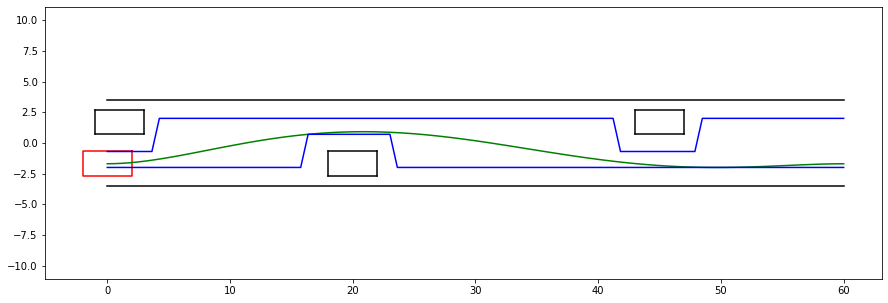

In [29]:
Y = [m.pt[0, i]() for i in range(N)]
plt.figure(figsize=(15,5)) 
ego_cps = local2global(ego.x, ego.y, ego.yaw, ego.corner_points)
plt.plot(ego_cps[0], ego_cps[1], 'r')
for line in MAP_cars:
    plt.plot([line[0], line[2]], [line[1], line[3]], 'k')
plt.plot(X, road_bound_left.y*np.ones(N), 'k')
plt.plot(X, road_bound_right.y*np.ones(N), 'k')
plt.plot(X, Y, 'g')
plt.plot(X, LB, 'b')
plt.plot(X, UB, 'b')
plt.axis('equal')    
plt.show()